In [1]:
import time
import os

import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
path = tf.keras.utils.get_file('facades.tar.gz', 
                               'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz', 
                               extract=True)
path = os.path.join(os.path.dirname(path), 'facades/')

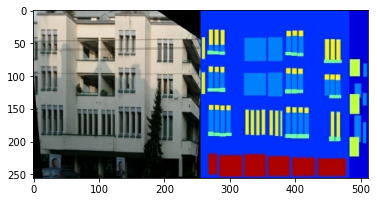

In [3]:
encoded_img = tf.io.read_file(path + 'train/1.jpg')
img = tf.image.decode_image(encoded_img)
plt.imshow(img)

In [4]:
def load(path):
    encoded_img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(encoded_img)
    
    w = tf.shape(img)[1]
    half_w = w // 2
    
    real = img[:, :half_w, :]
    inp = img[:, half_w:, :]
    
    real = tf.cast(real, tf.float32)
    inp = tf.cast(inp, tf.float32)

    return inp, real

def jitter(inp, real):
    stacked_img = tf.stack((inp, real), axis=0)
    stacked_img = tf.image.resize(stacked_img, (286, 286))
    cropped_img = tf.image.random_crop(stacked_img, (2, 256, 256, 3))
    inp, real = cropped_img[0], cropped_img[1]
    
    if tf.random.uniform(()) > .5:
        inp = tf.image.flip_left_right(inp)
        real = tf.image.flip_left_right(real)

    return inp, real

def normalize(inp, real):
    inp = inp / 127.5 - 1
    real = real / 127.5 - 1
    return inp, real

In [5]:
def load_train_ds(path):
    inp, real = load(path)
    inp, real = jitter(inp, real)
    inp, real = normalize(inp, real)
    return inp, real

def load_test_ds(path):
    inp, real = load(path)
    inp, real = normalize(inp, real)
    return inp, real

In [6]:
train_ds = tf.data.Dataset.list_files(path + 'train/*.jpg')
train_ds = train_ds.map(load_train_ds, num_parallel_calls=-1)
train_ds = train_ds.shuffle(5278).batch(1)

test_ds = tf.data.Dataset.list_files(path + 'test/*.jpg')
test_ds = test_ds.map(load_test_ds, num_parallel_calls=-1)
test_ds = test_ds.batch(1)

In [7]:
class DownSample(tf.keras.models.Model):
    def __init__(self, filters, size, apply_batchnorm=True):
        super().__init__()
        
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', use_bias=False, 
                                              kernel_initializer=tf.random_normal_initializer(0, 0.02)))
    
        if apply_batchnorm:
            self.model.add(tf.keras.layers.BatchNormalization())
    
        self.model.add(tf.keras.layers.LeakyReLU())
        
    def call(self, inputs):
        outputs = self.model(inputs)
        return outputs
    
    
class UpSample(tf.keras.models.Model):
    def __init__(self, filters, size, apply_dropout=False):
        super().__init__()
        
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', use_bias=False, 
                                                       kernel_initializer=tf.random_normal_initializer(0, 0.02)))
        self.model.add(tf.keras.layers.BatchNormalization())
        
        if apply_dropout:
            self.model.add(tf.keras.layers.Dropout(0.5))
    
        self.model.add(tf.keras.layers.LeakyReLU())
        
    def call(self, inputs):
        outputs = self.model(inputs)
        return outputs

In [8]:
def Generator():
    inp = tf.keras.layers.Input((256, 256, 3))

    down_stack = [DownSample(64, 4, apply_batchnorm=False),
                  DownSample(128, 4),
                  DownSample(256, 4),
                  DownSample(512, 4),
                  DownSample(512, 4),
                  DownSample(512, 4),
                  DownSample(512, 4),
                  DownSample(512, 4)]     

    up_stack = [UpSample(512, 4, apply_dropout=True), 
                UpSample(512, 4, apply_dropout=True), 
                UpSample(512, 4, apply_dropout=True), 
                UpSample(512, 4), 
                UpSample(256, 4), 
                UpSample(128, 4), 
                UpSample(64, 4)]      

    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh', 
                                           kernel_initializer=tf.random_normal_initializer(0, 0.02))

    x = inp

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()((x, skip))

    fake = last(x)

    return tf.keras.Model(inputs=inp, outputs=fake)

In [9]:
def Discriminator(): 
    inp = tf.keras.layers.Input((256, 256, 3))
    fake_or_real = tf.keras.layers.Input((256, 256, 3))

    # (None, 256, 256, channels*2)
    x = tf.keras.layers.Concatenate()((inp, fake_or_real))

    down1 = DownSample(64, 4, apply_batchnorm=False)(x)
    down2 = DownSample(128, 4)(down1)
    down3 = DownSample(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, use_bias=False, kernel_initializer=tf.random_normal_initializer(0, 0.02))(zero_pad1)
    batch_norm = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    pred = tf.keras.layers.Conv2D(1, 4, kernel_initializer=tf.random_normal_initializer(0, 0.02))(zero_pad2)

    return tf.keras.Model(inputs=(inp, fake_or_real), outputs=pred)

In [10]:
gen = Generator()
disc = Discriminator()

In [11]:
def show(num):
    for inp, real in train_ds.take(num):
        fake = gen(inp, training=True)
        imgs = (inp[0], real[0], fake[0])
        titles = ('Input', 'Real', 'Fake')

        plt.figure(figsize=(10, 10))
        for i in range(3):
            plt.subplot(num, num*3, i+1)
            plt.title(titles[i])
            plt.imshow(0.5 * imgs[i] + 0.5)
            plt.axis(False)

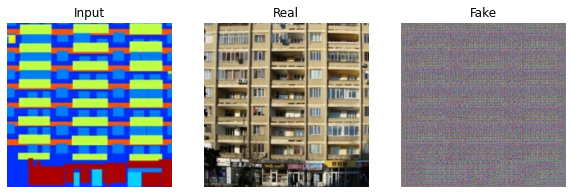

In [12]:
show(1)

In [13]:
def gen_loss(fake, real, fake_pred):
    gan_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_pred), 
                                                   fake_pred, 
                                                   from_logits=True)
    l1_loss = tf.reduce_mean(tf.abs(real - fake))
    
    loss = gan_loss + 100 * l1_loss
    return loss

In [14]:
def disc_loss(fake_pred, real_pred):
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_pred), 
                                                   fake_pred, 
                                                   from_logits=True)
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_pred), 
                                                   real_pred, 
                                                   from_logits=True)
    loss = fake_loss + real_loss
    return loss

In [15]:
gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [16]:
file_prefix = './ckpt/Pix2Pix'
checkpoint = tf.train.Checkpoint(gen_opt=gen_opt, 
                                 disc_opt=disc_opt, 
                                 gen=gen, 
                                 disc=disc)

In [17]:
@tf.function
def train_step(inp, real):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake = gen(inp, training=True)
        real_pred = disc((inp, real), training=True)
        fake_pred = disc((inp, fake), training=True)
        

        
        gen_grads = gen_tape.gradient(gen_loss(fake, real, fake_pred), 
                                      gen.trainable_variables)
        disc_grads = disc_tape.gradient(disc_loss(fake_pred, real_pred), 
                                        disc.trainable_variables)
        
        gen_opt.apply_gradients(zip(gen_grads, gen.trainable_variables))
        disc_opt.apply_gradients(zip(disc_grads, disc.trainable_variables))

In [18]:
steps = 50

for step in range(steps):
    start = time.time()
    
    for inp, real in train_ds:
        train_step(inp, real)
        
    if (step + 1) % 10 == 0:
        checkpoint.save(file_prefix)
        
    end = time.time()
    duration = end - start
    print(f"step: {step}, duration: {duration:.2f}s")
    
checkpoint.save(file_prefix)

step: 0, duration: 258.52169132232666s
step: 1, duration: 253.80735325813293s
step: 2, duration: 255.74452543258667s
step: 3, duration: 256.25897884368896s
step: 4, duration: 257.9458246231079s
step: 5, duration: 260.7454504966736s
step: 6, duration: 252.41575694084167s
step: 7, duration: 253.349750995636s
step: 8, duration: 251.62119030952454s
step: 9, duration: 251.87282824516296s
step: 10, duration: 257.3543117046356s
step: 11, duration: 254.5434868335724s
step: 12, duration: 255.9694037437439s
step: 13, duration: 254.49437355995178s
step: 14, duration: 254.5548267364502s
step: 15, duration: 252.18563437461853s
step: 16, duration: 265.50362849235535s
step: 17, duration: 276.4933183193207s
step: 18, duration: 262.5909481048584s
step: 19, duration: 258.35544991493225s
step: 20, duration: 259.74117279052734s
step: 21, duration: 259.172976732254s
step: 22, duration: 261.3416953086853s
step: 23, duration: 259.3121716976166s
step: 24, duration: 256.9297020435333s
step: 25, duration: 256.7

'./ckpt/Pix2Pix-6'

In [21]:
checkpoint.restore('./ckpt/Pix2Pix-6')

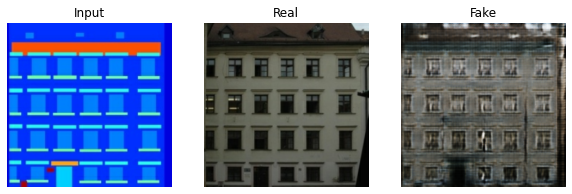

In [22]:
show(1)

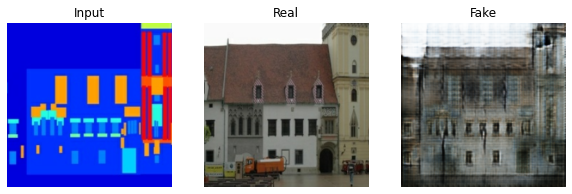

In [20]:
show(1)

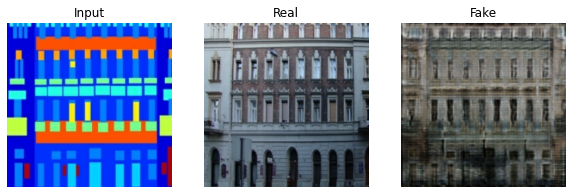

In [21]:
show(1)

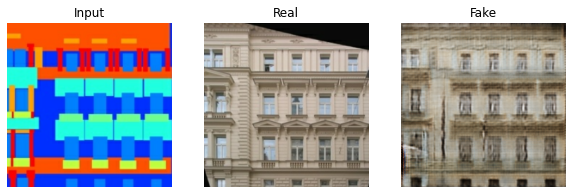

In [23]:
show(1)

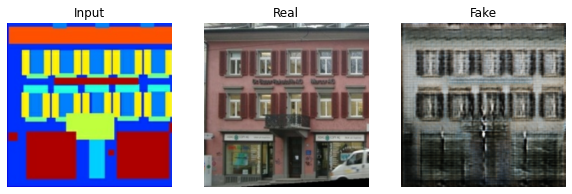

In [24]:
show(1)